In [1]:
import bayesfast as bf
import numpy as np

In [2]:
from distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=4, threads_per_worker=1)
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:41089 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 540.15 GB


In [3]:
a = 5
b = 0.5

def f_0(x):
    return np.linalg.norm(x, 2, -1)

def j_0(x):
    '''not actually used'''
    foo = x / np.linalg.norm(x, 2, -1)
    return foo if np.all(np.isfinite(foo)) else np.ones_like(foo)

def f_1(x):
    return -(x - a)**2 / b

def j_1(x):
    return -2 * (x - a) / b

m_0 = bf.Module(f_0, input_vars='in', output_vars='model')
m_1 = bf.Module(f_1, j_1, input_vars='model', output_vars='logp')
d_0 = bf.Density(module_list=[m_0, m_1], var_dims=[2], input_vars='in', 
                 density_name='logp')

s_0 = bf.modules.PolyModel('linear', 2, 1, input_vars='in', 
                           output_vars='model')
s_1 = bf.modules.PolyModel('quadratic', 2, 1, input_vars='in',
                           output_vars='model')
opt_0 = bf.recipe.OptimizeStep(s_0, hmc_options={'n_iter':1500, 'n_warmup':500})
sam_0 = bf.recipe.SampleStep(s_1, alpha_n=5, reuse_steps=0, 
                             sample_options={'n_iter':1500, 'n_warmup':500})

x_0 = bf.utils.random.multivariate_normal([10, 10], np.eye(2), 20)
r_0 = bf.recipe.Recipe(density=d_0, client=client, optimize=opt_0, 
                       sample=[sam_0] * 10, x_0=x_0, random_state=0)

In [4]:
r_0.run()

 OptimizeStep proceeding: iter #0 finished.


/global/u2/h/hejia/bayesfast/bayesfast/utils/laplace.py:68: RuntimeWarning: the optimization stopped at [5.0055736  2.29704006], but probably it has not converged yet.
  'converged yet.'.format(opt.x), RuntimeWarning)


 OptimizeStep proceeding: iter #1 finished, while delta_pp = 12.433, delta_pq = 0.079.


/global/u2/h/hejia/bayesfast/bayesfast/utils/laplace.py:68: RuntimeWarning: the optimization stopped at [4.77779242 2.19629945], but probably it has not converged yet.
  'converged yet.'.format(opt.x), RuntimeWarning)


 OptimizeStep proceeding: iter #2 finished, while delta_pp = 0.383, delta_pq = 0.014.


/global/u2/h/hejia/bayesfast/bayesfast/utils/laplace.py:68: RuntimeWarning: the optimization stopped at [4.62525613 2.12668694], but probably it has not converged yet.
  'converged yet.'.format(opt.x), RuntimeWarning)


 OptimizeStep proceeding: iter #3 finished, while delta_pp = 0.117, delta_pq = 0.000.
 OptimizeStep proceeding: iter #4 finished, while delta_pp = 0.016, delta_pq = -0.000.

 ***** OptimizeStep finished. ***** 

 CHAIN #3 : sampling proceeding [ 150 / 1500 ], last 150 samples used 0.51 seconds. (warmup)
 CHAIN #1 : sampling proceeding [ 150 / 1500 ], last 150 samples used 0.62 seconds. (warmup)
 CHAIN #0 : sampling proceeding [ 150 / 1500 ], last 150 samples used 0.62 seconds. (warmup)
 CHAIN #2 : sampling proceeding [ 150 / 1500 ], last 150 samples used 0.75 seconds. (warmup)
 CHAIN #3 : sampling proceeding [ 300 / 1500 ], last 150 samples used 0.40 seconds. (warmup)
 CHAIN #0 : sampling proceeding [ 300 / 1500 ], last 150 samples used 0.52 seconds. (warmup)
 CHAIN #1 : sampling proceeding [ 300 / 1500 ], last 150 samples used 0.62 seconds. (warmup)
 CHAIN #3 : sampling proceeding [ 450 / 1500 ], last 150 samples used 0.35 seconds. (warmup)
 CHAIN #2 : sampling proceeding [ 300 / 1500

Removed no burn in


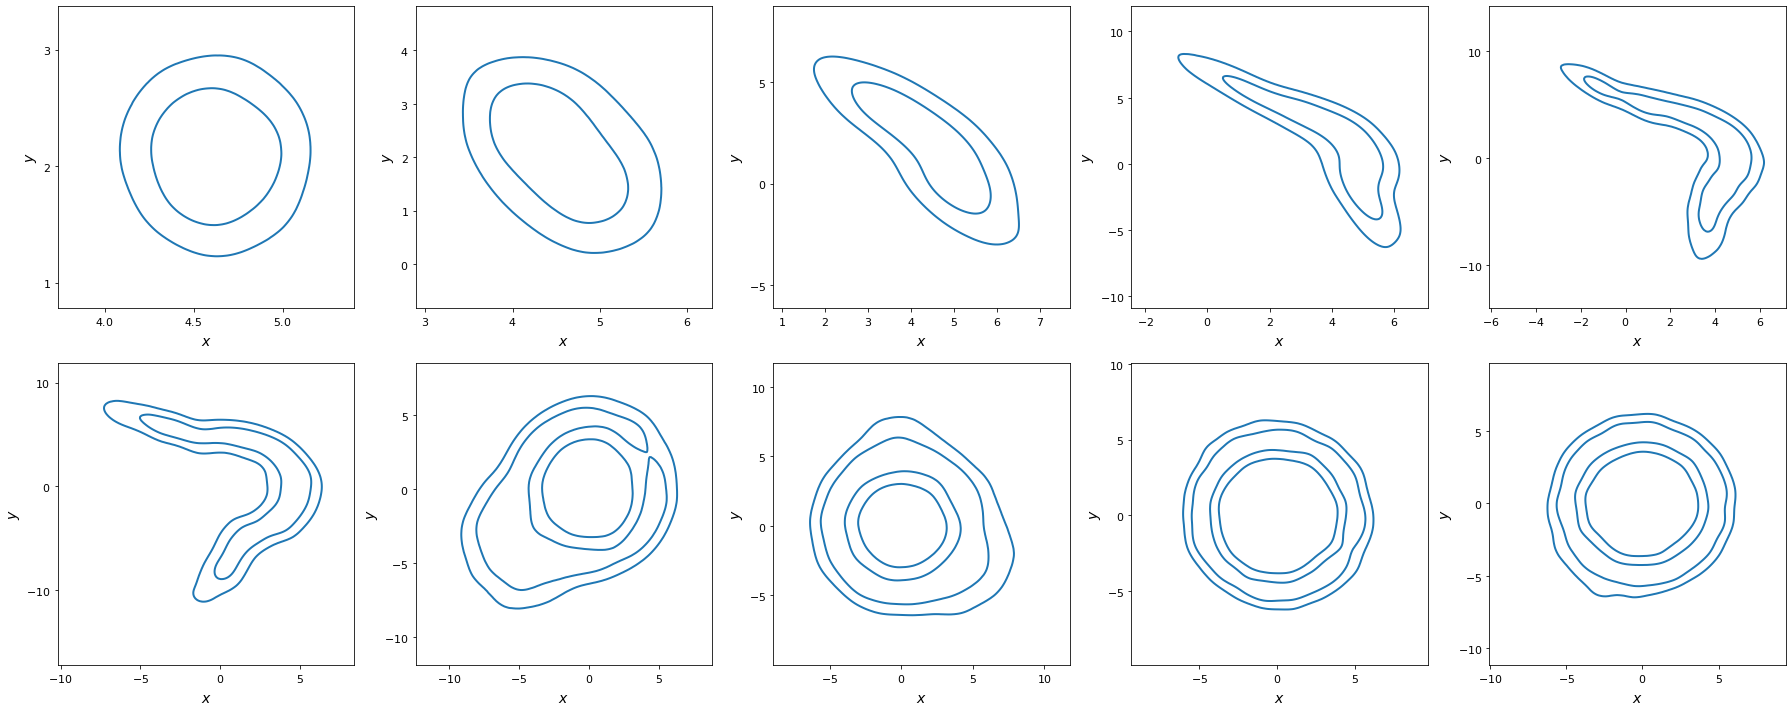

In [7]:
%matplotlib inline
from getdist import plots, MCSamples
import matplotlib.pyplot as plt

g = plots.get_subplot_plotter(subplot_size=5)
sa = MCSamples(samples=np.concatenate([si.samples.reshape((-1, 2)) for si in 
               r_0.result.data.sample], axis=-1), names=['x_{}'.format(i) for i 
               in range(20)], labels=['x', 'y'] * 10)
g.plots_2d(sa, param_pairs=[['x_{}'.format(i), 'x_{}'.format(i + 1)] for i in 
           range(0, 20, 2)], nx=5, colors=['tab:blue'], lws=[2])

plt.show()